In [1]:
import pandas as pd
import sklearn
import numpy as np
import pickle

from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn import svm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('anomaly.csv')

In [4]:
data.columns = ['x','y']

Number of datapoints : 1004


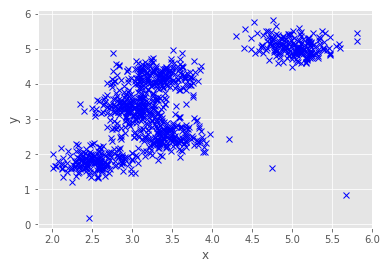

In [5]:
arr_data = data.values

n_samples = arr_data.shape[0]

print('Number of datapoints : %d' % n_samples)

plt.xlabel('x')
plt.ylabel('y')
plt.plot(arr_data[:,0],arr_data[:,1],'bx')
plt.show()

### Anomaly detection through Clustering

###### The idea here is to cluster the data points, the anomalies are the farthest points from any centroid

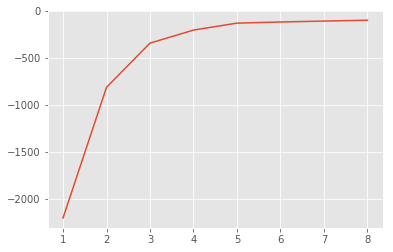

In [21]:
# calculate with different number of centroids to see the loss plot
n_cluster = range(1, 9)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [7]:
df = pd.DataFrame()
df['cluster'] = kmeans[7].predict(data)
df['x'] = data.values[:,0]
df['y'] = data.values[:,1]
df['cluster'].value_counts()

2    198
1    158
3    143
0    114
6    107
7    104
4     94
5     86
Name: cluster, dtype: int64

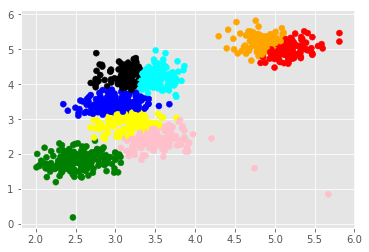

In [8]:
#plot the different clusters
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['x'], df['y'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [9]:
from distance import getDistanceByPoint

/home/marouenhizaoui/Documents/Projects/Yazzoom/distance.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  distance.set_value(i, min(dist))


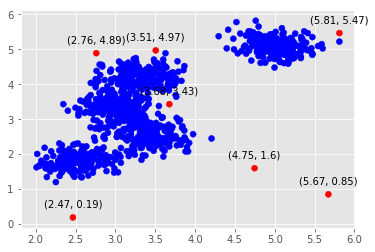

In [10]:
#the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[7])
number_of_outliers = int(0.007*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

df['anomaly'] = (distance >= threshold).astype(int)

# visualisation
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['x'], df['y'], c=df["anomaly"].apply(lambda x: colors[x]))
df_a = df[df['anomaly'] == 1]
for x,y in zip(df_a['x'],df_a['y']):

    x_ = "{0:.2f}".format(x)
    y_ = "{0:.2f}".format(y)
    label = (float(x_),float(y_))

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset pixels", 
                 xytext=(0,10),
                 ha='center') 

plt.show()

In [11]:
#The threshold to be used in the API
threshold

0.6861943678574741

In [12]:
#export the model as a pickle file to be used by the API
#pickle.dump(kmeans[1],open('model.pickle','wb'))

## Additional approaches:

### Multivariate Anomaly Detection

In [13]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


In [14]:
mu, sigma = estimateGaussian(data.values)
p = multivariateGaussian(data.values,mu,sigma)


In [15]:
p.mean()

0.10601532883827434

In [16]:
outliers = np.asarray(np.where(p < 0.01))


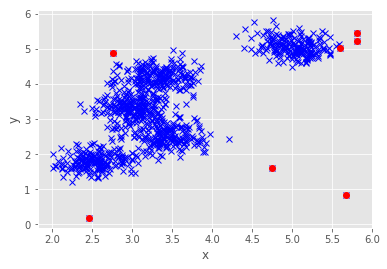

In [17]:

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(arr_data[:,0],arr_data[:,1],'bx')
plt.plot(arr_data[outliers,0],arr_data[outliers,1],'ro')
plt.show()

### Anomaly detection through One Class modeling

In [18]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(arr_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [19]:
pred = clf.predict(arr_data)
normal = arr_data[pred == 1]
abnormal = arr_data[pred == -1]

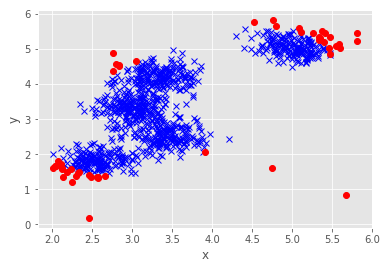

In [20]:
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.show()